## 1. Metrics and Plots

### Analysing the pcap file:


Total amount of data transferred (in bytes)

Total number of packets transferred

Minimum, maximum, and average packet sizes

In [1]:
from scapy.all import rdpcap
from tqdm import tqdm

packets = rdpcap("final_captured.pcap")
total_data = 0
total_packets = len(packets)
packet_sizes = []

for packet in tqdm(packets):
    packet_sizes.append(len(packet))
    total_data += len(packet)

min_size = min(packet_sizes)
max_size = max(packet_sizes)
avg_size = total_data / total_packets

print(f"Total data transferred: {total_data} bytes")
print(f"Total number of packets: {total_packets}")
print(f"Min Packet Size: {min_size} bytes")
print(f"Max Packet Size: {max_size} bytes")
print(f"Avg Packet Size: {avg_size:.2f} bytes")

100%|██████████| 792184/792184 [00:10<00:00, 75325.05it/s]


Total data transferred: 355624564 bytes
Total number of packets: 792184
Min Packet Size: 42 bytes
Max Packet Size: 1514 bytes
Avg Packet Size: 448.92 bytes


In [1]:
# analysis on original pcap file
from scapy.all import rdpcap

packets = rdpcap("4.pcap")
total_data = 0
total_packets = len(packets)
packet_sizes = []

for packet in packets:
    packet_sizes.append(len(packet))
    total_data += len(packet)

min_size = min(packet_sizes)
max_size = max(packet_sizes)
avg_size = total_data / total_packets

print(f"Total data transferred: {total_data} bytes")
print(f"Total number of packets: {total_packets}")
print(f"Min Packet Size: {min_size} bytes")
print(f"Max Packet Size: {max_size} bytes")
print(f"Avg Packet Size: {avg_size:.2f} bytes")

Total data transferred: 355624326 bytes
Total number of packets: 792179
Min Packet Size: 54 bytes
Max Packet Size: 1514 bytes
Avg Packet Size: 448.92 bytes


Distribution of packet sizes

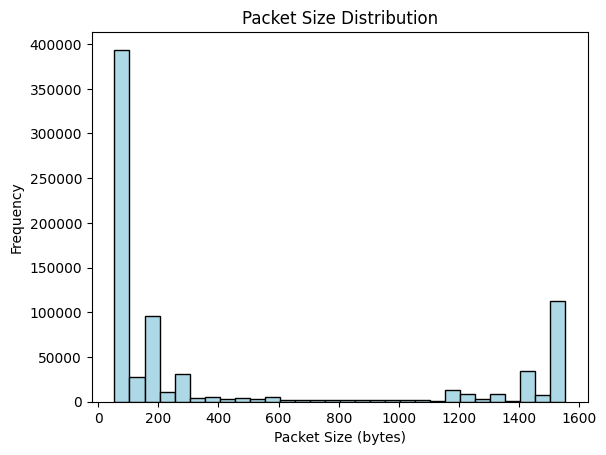

In [4]:
import matplotlib.pyplot as plt
from scapy.all import rdpcap

bin_width = 50
plt.hist(packet_sizes, bins=range(min(packet_sizes), max(packet_sizes) + bin_width, bin_width), color='lightblue', edgecolor='black')
plt.title('Packet Size Distribution')
plt.xlabel('Packet Size (bytes)')
plt.ylabel('Frequency')
plt.show()


### Identify Unique Source-Destination Pairs (source IP:port and destination IP:port) in the captured data


In [ ]:
from scapy.all import rdpcap, IP, TCP, UDP
from collections import defaultdict
from tqdm import tqdm  

unique_pairs = defaultdict(int)

for packet in tqdm(packets):
    if packet.haslayer(IP):  
        src_ip = packet[IP].src
        dst_ip = packet[IP].dst
        src_port, dst_port = None, None  

        if packet.haslayer(TCP):
            src_port = packet[TCP].sport
            dst_port = packet[TCP].dport
        elif packet.haslayer(UDP):
            src_port = packet[UDP].sport
            dst_port = packet[UDP].dport

        if src_port is not None and dst_port is not None:  
            unique_pairs[(f"{src_ip}:{src_port}", f"{dst_ip}:{dst_port}")] += len(packet)

for pair, total_size in unique_pairs.items():
    print(f"{pair}: {total_size} bytes")


### Flow Analysis


Key: IP Address; Value: Total flows originating from that IP (as source).

Key: IP Address; Value: Total flows terminating at that IP (as destination).

In [ ]:
from scapy.all import rdpcap

src_flows = {}
dst_flows = {}

# Analyze packet flows
for packet in packets:
    if packet.haslayer(IP):
        src_ip = packet[IP].src
        dst_ip = packet[IP].dst
        if src_ip not in src_flows:
            src_flows[src_ip] = 0
        if dst_ip not in dst_flows:
            dst_flows[dst_ip] = 0
        src_flows[src_ip] += 1
        dst_flows[dst_ip] += 1

print("Source Flows:")
for ip, flow in src_flows.items():
    print(f"{ip}: {flow} flows originating")
    
print("\nDestination Flows:")
for ip, flow in dst_flows.items():
    print(f"{ip}: {flow} flows terminating")


Find which source-destination pair has transferred the most data

In [12]:
max_pair = max(unique_pairs, key=unique_pairs.get)  # Find key with max value
max_data = unique_pairs[max_pair]
print(f"Source-Destination pair with most data: {max_pair} with {max_data} bytes")


Source-Destination pair with most data: ('172.16.133.95:49358', '157.56.240.102:443') with 17342229 bytes


## 2. Hiding a Message in TCP Packet Payload

Extracting the hidden message

In [13]:
from scapy.all import rdpcap, TCP

# Filtering packets with source port 1579
filtered_packets = [pkt for pkt in packets if pkt.haslayer(TCP) and pkt[TCP].sport == 1579]

# Extract hidden messages
hidden_messages = []
packet_count = 0
protocols = set()
checksum_values = []

for pkt in filtered_packets:
    if pkt.haslayer(TCP) and pkt[TCP].payload:
        payload = bytes(pkt[TCP].payload).decode(errors="ignore")
        
        if "CS331" in payload:
            hidden_messages.append(payload)
            packet_count += 1
            protocols.add(pkt.payload.name)  
            checksum_values.append(pkt[TCP].chksum)  # Store TCP checksum

In [14]:
print("Hidden Messages Extracted:")
for msg in hidden_messages:
    print(msg)

Hidden Messages Extracted:
Welcome to Computer Networks CS331
Welcome to Computer Networks CS331
Welcome to Computer Networks CS331
Welcome to Computer Networks CS331
Welcome to Computer Networks CS331
Welcome to Computer Networks CS331
Welcome to Computer Networks CS331
Welcome to Computer Networks CS331
Welcome to Computer Networks CS331
Welcome to Computer Networks CS331
Welcome to Computer Networks CS331


Number of messages with hidden messages

In [15]:
print("Number of Packets Containing Hidden Message:", packet_count)

Number of Packets Containing Hidden Message: 11


Protocol used to transmit the packet containing the hidden message

In [16]:
#Printing the protocols used at each level in the filtered packets
for pkt in filtered_packets: 
    layers = []
    layer = pkt
    while layer:
        layers.append(layer.name)
        layer = layer.payload
    print(" → ".join(layers))

Ethernet → IP → TCP → Raw
Ethernet → IP → TCP → Raw
Ethernet → IP → TCP → Raw
Ethernet → IP → TCP → Raw
Ethernet → IP → TCP → Raw
Ethernet → IP → TCP → Raw
Ethernet → IP → TCP → Raw
Ethernet → IP → TCP → Raw
Ethernet → IP → TCP → Raw
Ethernet → IP → TCP → Raw
Ethernet → IP → TCP → Raw
Ethernet → IP → TCP → Raw
Ethernet → IP → TCP → Raw
Ethernet → IP → TCP → Raw
Ethernet → IP → TCP → Raw
Ethernet → IP → TCP → Raw
Ethernet → IP → TCP → Raw
Ethernet → IP → TCP → Raw
Ethernet → IP → TCP → Raw
Ethernet → IP → TCP → Raw
Ethernet → IP → TCP → Raw
Ethernet → IP → TCP → Raw
Ethernet → IP → TCP → Raw
Ethernet → IP → TCP → Raw
Ethernet → IP → TCP → Raw
Ethernet → IP → TCP → Raw
Ethernet → IP → TCP → Raw
Ethernet → IP → TCP → Raw
Ethernet → IP → TCP → Raw
Ethernet → IP → TCP → Raw
Ethernet → IP → TCP → Raw
Ethernet → IP → TCP → Raw
Ethernet → IP → TCP → Raw
Ethernet → IP → TCP → Raw
Ethernet → IP → TCP → Raw


In [17]:
print("Protocol Used:", list(protocols))

Protocol Used: ['IP']


Checksum of the TCP segment containing the hidden message

In [18]:
print("TCP Checksum of Relevant Packets:", checksum_values)

TCP Checksum of Relevant Packets: [547, 755, 908, 703, 958, 599, 651, 858, 443, 807, 495]
